In [ ]:
import mailbox
import gensim
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import *
import eml_parser, json, datetime
import email
import pandas as pd
import numpy as np
import os
import joblib

# NLP with NLTK
import nltk
nltk.download("stopwords")
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# For visualization
from wordcloud import WordCloud
#import pyLDAvis
#import pyLDAvis.gensim

# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Keras
import tensorflow as tf
from tensorflow.keras import layers

# Data preprocessing

## Extracting the body text

In [179]:
# From https://stackoverflow.com/questions/7166922/extracting-the-body-of-an-email-from-mbox-file-decoding-it-to-plain-text-regard

def get_charsets(msg):
    charsets = set({})
    for c in msg.get_charsets():
        if c is not None:
            charsets.update([c])
    return charsets

def handle_error(errmsg, emailmsg,cs):
    '''print()
    print(errmsg)
    print("This error occurred while decoding with ",cs," charset.")
    print("These charsets were found in the one email.",get_charsets(emailmsg))
    print("This is the subject:",emailmsg['subject'])
    print("This is the sender:",emailmsg['From'])'''
    pass

def get_body_from_email(msg):
    body = None
    #Walk through the parts of the email to find the text body.    
    if msg.is_multipart():    
        for part in msg.walk():

            # If part is multipart, walk through the subparts.            
            if part.is_multipart(): 

                for subpart in part.walk():
                    if subpart.get_content_type() == 'text/plain':
                        # Get the subpart payload (i.e the message body)
                        body = subpart.get_payload(decode=True) 
                        #charset = subpart.get_charset()

            # Part isn't multipart so get the email body
            elif part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True)
                #charset = part.get_charset()

    # If this isn't a multi-part message then get the payload (i.e the message body)
    #elif msg.get_content_type() == 'text/plain':
        #body = msg.get_payload(decode=True) 
    
    # Uncomment this to also include html and other formats
    else:
        body = msg.get_payload(decode=True) 

    return body

### Phishing emails

In [180]:
phishingBoxFilenames = ["../datasets/monkey/phishing3.mbox","../datasets/monkey/phishing2.mbox", "../datasets/monkey/phishing1.mbox", "../datasets/monkey/phishing0.mbox",
                        "../datasets/monkey/phishing2022.mbox", "../datasets/monkey/phishing2021.mbox", "../datasets/monkey/phishing2020.mbox", "../datasets/monkey/phishing2019.mbox", "../datasets/monkey/phishing2018.mbox",
                       "../datasets/monkey/phishing2017.mbox", "../datasets/monkey/phishing2016.mbox", "../datasets/monkey/phishing2015.mbox"]
phishingBoxes = [mailbox.mbox(f) for f in phishingBoxFilenames]
phishingMessages = [m[1] for phishingBox in phishingBoxes for m in phishingBox.items()]

phishingMessageBodies = []
for p in phishingMessages:
    body = get_body_from_email(p)
    if body is not None and len(body) > 0:
        phishingMessageBodies.append(body)
        
print(len(phishingMessages), len(phishingMessageBodies))

4572 2754


In [ ]:
# Clair Fraud Email Database
added = []
with open("../datasets/clair/fraudulent_emails.txt", 'r', errors="ignore") as f:
    body = ""
    inBody = False
    for line in f:
        if line.startswith("Status: O"):
            inBody = True
        
        elif line.startswith("From r") and len(body) > 0:
            inBody = False
            added.append(body)
            body = ""

        elif inBody:
            body += line

phishingMessageBodies = list(set(phishingMessageBodies + [a for a in added if len(a) > 0]))
print(len(phishingMessageBodies))
    

In [182]:
# SpamAssassin Spam (not exactly phishing, but NVIDIA article used it as phishing so attempting it)
ep = eml_parser.EmlParser(include_raw_body=True)

spamDir = "../datasets/spamassassin/spam_2/spam_2/"
spamFilenames = [os.path.join(spamDir, f) for f in os.listdir(spamDir)]

added = []
for filename in spamFilenames:
    with open(filename, "rb") as f:
        b = f.read()
    
    m = ep.decode_email_bytes(b)
    if len(m["body"]) >= 1:
        added.append(m["body"][0]["content"])
    
phishingMessageBodies = list(set(phishingMessageBodies + added))
print(len(phishingMessageBodies))

Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.

4821


### Benign emails

In [183]:
ep = eml_parser.EmlParser(include_raw_body=True)

easyHamDir = "../datasets/spamassassin/easy_ham/easy_ham/"
hardHamDir = "../datasets/spamassassin/hard_ham/hard_ham/"
hamFilenames = [os.path.join(easyHamDir, f) for f in os.listdir(easyHamDir)] + [os.path.join(hardHamDir, f) for f in os.listdir(hardHamDir)]

benignMessageBodies = []
for filename in hamFilenames:
    with open(filename, "rb") as f:
        b = f.read()
    
    m = ep.decode_email_bytes(b)
    if len(m["body"]) >= 1:
        benignMessageBodies.append(m["body"][0]["content"])
    
print(len(benignMessageBodies))

Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.

2801


In [184]:
# Personal, benign emails
personalBox = mailbox.mbox("../datasets/personal/gmail/benign.mbox")
personalMessages = [m[1] for m in personalBox.items()][:len(phishingMessageBodies)//3] # limit amount added

added = []
for p in personalMessages:
    body = get_body_from_email(p)
    if body is not None and len(body) > 0:
        added.append(body)

benignMessageBodies += added
print(len(benignMessageBodies))

4323


In [185]:
enronMailDir = "../datasets/enron/maildir_small/"

enronMessages = []
for directory, subdir, filenames in os.walk(enronMailDir):
    for filename in filenames:
        with open(os.path.join(directory, filename), "rb") as f:
            m = email.parser.Parser().parsestr(f.read().decode("utf-8", errors="ignore"))
            enronMessages.append(m)

added = []
for m in enronMessages:
    body = get_body_from_email(m)
    if body is not None and len(body) > 0:
        added.append(body)

# limit the amount added, so that benign is not >> phishing
if len(added) + len(benignMessageBodies) > len(phishingMessageBodies):
    toAdd = round((1.1 * len(phishingMessageBodies)) - len(benignMessageBodies))
    print(toAdd)
    added = added[:toAdd]

benignMessageBodies += added
print(len(benignMessageBodies))

980
5303


## Simple preprocessing

In [186]:
# Custom stop words and preprocessing filters

stopWords = nltk.corpus.stopwords
stopWords = stopWords.words("english")
stopWords.extend(["nbsp", "font", "sans", "serif", "bold", "arial", "verdana", "helvetica", "http", "https", "www", "html", "enron", "margin", "spamassassin"])

def remove_custom_stopwords(p):
    return remove_stopwords(p, stopwords=stopWords)

CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_custom_stopwords, remove_stopwords, strip_short, stem_text]

In [187]:
# Decode to utf-8 as needed

# Phishing
phishingDecoded = []
for b in phishingMessageBodies:
    try:
        p = b.decode("utf-8", errors="ignore")
    except AttributeError:
        p = b
    phishingDecoded.append(p)
phishingMessageBodies = phishingDecoded

# Benign
benignDecoded = []
for b in benignMessageBodies:
    try:
        p = b.decode("utf-8", errors="ignore")
    except AttributeError:
        p = b
    benignDecoded.append(p)
benignMessageBodies = benignDecoded

In [188]:
# Phishing emails
phishingPreprocessed = []
for b in phishingMessageBodies:
    p = preprocess_string(b, filters=CUSTOM_FILTERS)
    #p = gensim.parsing.preprocessing.remove_stopwords(p, stopwords=stopWords
    
    phishingPreprocessed.append(p)
print(len(phishingPreprocessed))

4821


In [189]:
# Benign emails
benignPreprocessed = []
for b in benignMessageBodies:
    p = preprocess_string(b, filters=CUSTOM_FILTERS)
    benignPreprocessed.append(p)
print(len(benignPreprocessed))

5303


# Word2vec

In [190]:
# Train the model on all messages
model = Word2Vec(phishingPreprocessed + benignPreprocessed, min_count=1, workers=3, window=5)

In [191]:
model.wv.most_similar("dollar", topn=20)

[('million', 0.8771820068359375),
 ('pound', 0.835473358631134),
 ('thousand', 0.8199453949928284),
 ('llar', 0.8103737235069275),
 ('sterl', 0.7795438766479492),
 ('billion', 0.7657280564308167),
 ('emillion', 0.7640974521636963),
 ('quadrupl', 0.7639614939689636),
 ('ten', 0.7588891983032227),
 ('thirti', 0.7549144625663757),
 ('gbp', 0.7397751808166504),
 ('cinq', 0.7269525527954102),
 ('milliom', 0.7263365983963013),
 ('sum', 0.7234614491462708),
 ('millio', 0.7232768535614014),
 ('lutz', 0.717158317565918),
 ('dolla', 0.7150030732154846),
 ('slobber', 0.7135447263717651),
 ('estim', 0.7082199454307556),
 ('ancien', 0.7078647613525391)]

In [192]:
model.wv["dollar"]

array([ 1.0434579 ,  1.5792087 , -0.20492308,  0.4844793 ,  0.2713335 ,
        0.5268665 ,  0.5354407 ,  2.3988278 , -4.027642  ,  0.8331856 ,
       -0.19110179, -3.2455664 , -0.8541209 , -0.6263656 ,  1.9553957 ,
        1.120782  , -0.50631493,  0.03150719,  1.9030588 , -0.1771327 ,
        0.3366315 ,  2.1387613 , -0.5205003 , -1.4690092 ,  0.49971166,
       -3.1076107 ,  1.5153282 , -4.0155706 ,  1.953885  , -0.9172147 ,
        1.972871  , -0.231783  , -0.36689323, -0.4945798 , -1.1569089 ,
        2.8094742 , -0.01640786, -1.2396212 ,  2.563973  , -3.3035362 ,
        0.4665597 , -0.757642  ,  1.541693  ,  0.67673445,  3.5879328 ,
        1.5686477 , -1.3444768 , -0.9174693 , -0.6196464 ,  0.71025485,
        1.0767586 ,  0.15271577, -1.8857561 , -0.2914614 , -0.50885075,
        0.16973539, -0.31749567,  1.6888337 , -1.4489156 , -0.09550829,
       -0.18258822,  2.7118845 , -0.92725605, -1.0902765 ,  0.33709738,
       -0.06002488,  0.22126031,  1.8513176 , -1.0374069 ,  2.12

# Wordcloud

## Both

In [193]:
#cloudString = ','.join(','.join(list(phishingPreprocessed + benignPreprocessed)))
'''cloudString = ""
for doc in phishingPreprocessed + benignPreprocessed:
    cloudString += ",".join(doc)'''

'cloudString = ""\nfor doc in phishingPreprocessed + benignPreprocessed:\n    cloudString += ",".join(doc)'

In [194]:
'''wordCloud = WordCloud(max_words=5000, background_color="white")
wordCloud.generate(cloudString)
wordCloud.to_image()'''

'wordCloud = WordCloud(max_words=5000, background_color="white")\nwordCloud.generate(cloudString)\nwordCloud.to_image()'

# LDA Topic Modeling

In [195]:
numTopics = 1024

## Both

In [196]:
# Create dictionary and corpus
dictionary = gensim.corpora.Dictionary(phishingPreprocessed + benignPreprocessed)
corpus = [dictionary.doc2bow(text) for text in phishingPreprocessed + benignPreprocessed] # Term document frequency

In [197]:
joblib.dump(dictionary, "../models/ldaDictionary.joblib")

['../models/ldaDictionary.joblib']

In [198]:
# Create model
ldaModel = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=numTopics)

In [199]:
# Print keyword for the topics
print(ldaModel.print_topics())

[(933, '0.019*"com" + 0.015*"exmh" + 0.010*"list" + 0.010*"voter" + 0.008*"gift" + 0.008*"like" + 0.007*"linux" + 0.007*"email" + 0.006*"imag" + 0.006*"user"'), (941, '0.029*"com" + 0.012*"account" + 0.012*"paypal" + 0.011*"email" + 0.010*"zoom" + 0.010*"click" + 0.006*"new" + 0.006*"monei" + 0.005*"venmo" + 0.005*"offer"'), (334, '0.010*"ebai" + 0.006*"new" + 0.005*"account" + 0.005*"inform" + 0.005*"user" + 0.004*"agreement" + 0.004*"mail" + 0.004*"com" + 0.004*"monei" + 0.004*"year"'), (689, '0.053*"com" + 0.021*"ebai" + 0.013*"click" + 0.009*"universalstudio" + 0.009*"email" + 0.009*"help" + 0.008*"netflix" + 0.005*"polici" + 0.005*"url" + 0.005*"privaci"'), (561, '0.025*"org" + 0.021*"campaign" + 0.021*"click" + 0.010*"ebai" + 0.008*"email" + 0.007*"monei" + 0.007*"visit" + 0.007*"follow" + 0.007*"help" + 0.006*"account"'), (590, '0.028*"account" + 0.012*"inform" + 0.010*"access" + 0.009*"paypal" + 0.008*"secur" + 0.007*"limit" + 0.007*"fund" + 0.006*"monei" + 0.006*"protect" + 0.

In [200]:
joblib.dump(ldaModel, "../models/ldaModel.joblib")

['../models/ldaModel.joblib']

In [201]:
'''# Visualize LDA
pyLDAvis.enable_notebook()

ldavis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)
pyLDAvis.save_html(ldavis, "../results/ldavis_both.html")
#ldavis'''

'# Visualize LDA\npyLDAvis.enable_notebook()\n\nldavis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)\npyLDAvis.save_html(ldavis, "../results/ldavis_both.html")\n#ldavis'

## Phishing

In [202]:
'''# Create dictionary and corpus
dictionaryPhishing= gensim.corpora.Dictionary(phishingPreprocessed)
corpusPhishing = [dictionaryPhishing.doc2bow(text) for text in phishingPreprocessed] # Term document frequency'''

'# Create dictionary and corpus\ndictionaryPhishing= gensim.corpora.Dictionary(phishingPreprocessed)\ncorpusPhishing = [dictionaryPhishing.doc2bow(text) for text in phishingPreprocessed] # Term document frequency'

In [203]:
'''# Create model
ldaModelPhishing = gensim.models.LdaMulticore(corpus=corpusPhishing, id2word=dictionaryPhishing, num_topics=numTopics)'''

'# Create model\nldaModelPhishing = gensim.models.LdaMulticore(corpus=corpusPhishing, id2word=dictionaryPhishing, num_topics=numTopics)'

In [204]:
'''# Visualize LDA
pyLDAvis.enable_notebook()

ldavisPhishing = pyLDAvis.gensim.prepare(ldaModelPhishing, corpusPhishing, dictionaryPhishing)
pyLDAvis.save_html(ldavisPhishing, "../results/ldavis_phishing.html")
#ldavisPhishing'''

'# Visualize LDA\npyLDAvis.enable_notebook()\n\nldavisPhishing = pyLDAvis.gensim.prepare(ldaModelPhishing, corpusPhishing, dictionaryPhishing)\npyLDAvis.save_html(ldavisPhishing, "../results/ldavis_phishing.html")\n#ldavisPhishing'

## Benign

In [205]:
'''# Create dictionary and corpus
dictionaryBenign = gensim.corpora.Dictionary(benignPreprocessed)
corpusBenign = [dictionaryBenign.doc2bow(text) for text in benignPreprocessed] # Term document frequency'''

'# Create dictionary and corpus\ndictionaryBenign = gensim.corpora.Dictionary(benignPreprocessed)\ncorpusBenign = [dictionaryBenign.doc2bow(text) for text in benignPreprocessed] # Term document frequency'

In [206]:
'''# Create model
ldaModelBenign = gensim.models.LdaMulticore(corpus=corpusBenign, id2word=dictionaryBenign, num_topics=numTopics)'''

'# Create model\nldaModelBenign = gensim.models.LdaMulticore(corpus=corpusBenign, id2word=dictionaryBenign, num_topics=numTopics)'

In [207]:
'''# Visualize LDA
pyLDAvis.enable_notebook()

ldavisBenign = pyLDAvis.gensim.prepare(ldaModelBenign, corpusBenign, dictionaryBenign)
pyLDAvis.save_html(ldavisBenign, "../results/ldavis_benign.html")
#ldavisBenign'''

'# Visualize LDA\npyLDAvis.enable_notebook()\n\nldavisBenign = pyLDAvis.gensim.prepare(ldaModelBenign, corpusBenign, dictionaryBenign)\npyLDAvis.save_html(ldavisBenign, "../results/ldavis_benign.html")\n#ldavisBenign'

# Doc2Vec

In [208]:
taggedDocs = [TaggedDocument(doc, [i]) for i, doc in enumerate(phishingPreprocessed + benignPreprocessed)]

In [209]:
doc2VecModel = Doc2Vec(taggedDocs, vector_size=20, window=2, min_count=1, workers=4)

In [210]:
joblib.dump(doc2VecModel, "../models/doc2VecModel.joblib")

['../models/doc2VecModel.joblib']

# Classification

In [211]:
allPreprocessed = phishingPreprocessed + benignPreprocessed
allBodies = phishingMessageBodies + benignMessageBodies

In [212]:
# Blacklisted words and phrases pulled form spam wordlist
# Will be a list of lists. Each phrase/words is a list of preprocessed words If a given email has all of the stemmed/preprocessed words in a given list, it's a hit.

blackListWords = []
with open("spam_wordlist.txt", 'r') as f:
    for line in f:
        blackListWords.append(line)

blackList = []
for b in blackListWords:
    blackListEntry = preprocess_string(b, filters=CUSTOM_FILTERS)
    if len(blackListEntry) > 0 and blackListEntry not in blackList:
        blackList.append(blackListEntry)

In [213]:
# TF-IDF for the top set amount of words
maximumTermCount = 6

def preprocessor_func(s):
    sentence = " ".join(preprocess_string(s, filters=CUSTOM_FILTERS))
    return sentence

tfIDFVectorizer = TfidfVectorizer(max_features=maximumTermCount, preprocessor=preprocessor_func, sublinear_tf=True)
tfIDF = tfIDFVectorizer.fit_transform(allBodies).toarray()
print(tfIDFVectorizer.get_feature_names_out())
print(tfIDF.shape)

['account' 'bank' 'click' 'com' 'ebai' 'email']
(10124, 6)


In [214]:
joblib.dump(tfIDF, "../models/tfIDF.joblib")

['../models/tfIDF.joblib']

In [215]:
def count_all_upper_word(text):
    count = 0 
    for word in text.split():
        if word.upper() == word:
            count += 1

    return count

In [216]:
allVectors = []
for i in range(len(allBodies)):
    topTopics = ldaModel.get_document_topics(corpus[i], minimum_probability=0.0)
    
    # Can extend this array with other stuff later
    vec = [topTopics[i][1] for i in range(numTopics)] # Topics

    for v in doc2VecModel.infer_vector(allPreprocessed[i]): # Doc2Vec
        vec.append(v)

    # Sentiment analysis of polarity
    sia = SentimentIntensityAnalyzer()
    sentence = " ".join(allPreprocessed[i])
    polarity = sia.polarity_scores(sentence)
    for s in polarity:
        vec.append(polarity[s])

    # Contains HTML
    if "<html>" in allBodies[i].lower():
        vec.append(1)
    else:
        vec.append(0)

    # Contains a link (how many)
    if "http://" in allBodies[i].lower() or "https://" in allBodies[i].lower():
        vec.append(1)
    else:
        vec.append(0)

    # How many blacklisted phrases/words appear in this email
    for b in blackList:
        count = 0
        for word in b:
            if word in allPreprocessed[i]:
                count += 1
        vec.append(count)

    # TF-IDF for top terms
    for w in tfIDF[i]:
        vec.append(w)

    # Has all caps word?
    vec.append(count_all_upper_word(allBodies[i]))

    # Has exclamation marks?
    vec.append(allBodies[i].count("!"))

    # Total length
    vec.append(len(allBodies[i]))

    # Num words
    vec.append(len(allPreprocessed[i]))
    
    allVectors.append(vec)

In [217]:
print(np.array(allVectors).shape)

(10124, 1429)


In [218]:
allLabels = []
for i in range(len(phishingPreprocessed)):
    allLabels.append(1)
for i in range(len(benignPreprocessed)):
    allLabels.append(0)

In [219]:
# Scale and split data
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(allVectors)
X_train, X_test, y_train, y_test = train_test_split(scaler.transform(allVectors), allLabels, test_size=0.2, shuffle=True)

## Random Forest

In [220]:
rf = RandomForestClassifier()
#rf = make_pipeline(StandardScaler(), RandomForestClassifier())
rf.fit(X_train, y_train)

RandomForestClassifier()

In [221]:
y_pred = rf.predict(X_test)

rfcAccuracy = accuracy_score(y_test, y_pred)
rfcPrecision = precision_score(y_test, y_pred)
rfcRecall = recall_score(y_test, y_pred)

print("Accuracy:", rfcAccuracy)
print("Precision:", rfcPrecision)
print("Recall:", rfcRecall)

Accuracy: 0.9639506172839506
Precision: 0.9783783783783784
Recall: 0.9446764091858038


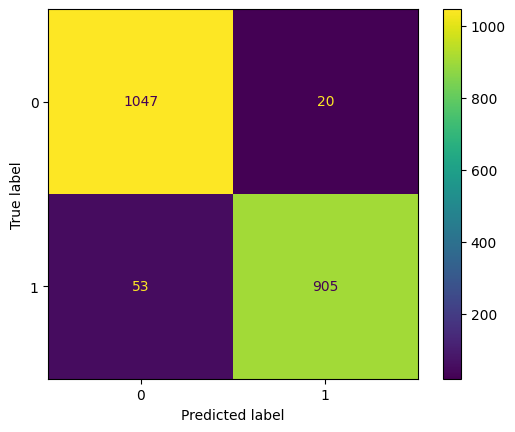

In [222]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [223]:
joblib.dump(rf, "../models/random_forest_model.joblib")

['../models/random_forest_model.joblib']

In [224]:
joblib.dump(scaler, "../models/rfcStandardScaler.joblib")

['../models/rfcStandardScaler.joblib']

In [225]:
def create_vectors_from_messages(messages, messagesPreprocessed):
    corpus = [dictionary.doc2bow(text) for text in messagesPreprocessed] # Term document frequency
    allPreprocessed = messagesPreprocessed
    allBodies = messages
    allVectors = []
    for i in range(len(allBodies)):
        topTopics = ldaModel.get_document_topics(corpus[i], minimum_probability=0.0)
        
        # Can extend this array with other stuff later
        vec = [topTopics[i][1] for i in range(numTopics)] # Topics
    
        for v in doc2VecModel.infer_vector(allPreprocessed[i]): # Doc2Vec
            vec.append(v)
    
        # Sentiment analysis of polarity
        sia = SentimentIntensityAnalyzer()
        sentence = " ".join(allPreprocessed[i])
        polarity = sia.polarity_scores(sentence)
        for s in polarity:
            vec.append(polarity[s])
    
        # Contains HTML
        if "<html>" in allBodies[i].lower():
            vec.append(1)
        else:
            vec.append(0)
    
        # Contains a link
        if "http://" in allBodies[i].lower() or "https://" in allBodies[i].lower():
            vec.append(1)
        else:
            vec.append(0)
    
        # How many blacklisted phrases/words appear in this email
        for b in blackList:
            count = 0
            for word in b:
                if word in allPreprocessed[i]:
                    count += 1
            vec.append(count)
    
        # TF-IDF for top terms
        for w in tfIDF[i]:
            vec.append(w)
    
        # Has all caps word?
        vec.append(count_all_upper_word(allBodies[i]))
    
        # Has exclamation marks?
        vec.append(allBodies[i].count("!"))
    
        # Total length
        vec.append(len(allBodies[i]))
    
        # Num words
        vec.append(len(allPreprocessed[i]))
        
        allVectors.append(vec)

    return allVectors

#box = mailbox.mbox("../datasets/monkey/phishing1.mbox")
box = mailbox.mbox("benign.mbox")
boxMessages = [m[1] for m in box.items()]
    
messages = []
for p in boxMessages:
    body = get_body_from_email(p)
    if body is not None and len(body) > 0:
        messages.append(body)

messagesDecoded = []
for m in messages:
    try:
        d = m.decode("utf-8", errors="ignore")
    except AttributeError:
        d = m
    messagesDecoded.append(d)
messages = messagesDecoded

# Apply preprocessing function to emails
messagesPreprocessed = []
for b in messages:
    p = preprocess_string(b, filters=CUSTOM_FILTERS)
    
    messagesPreprocessed.append(p)

allVectorsTest = create_vectors_from_messages(messages, messagesPreprocessed)
print("Shape of messages: {}".format(np.array(allVectorsTest).shape))

# RFC Prediction
#scaler = StandardScaler()
#scaler.fit(allVectors)
X = scaler.transform(allVectorsTest)
y_pred = rf.predict(X)
numPhishes = 0
for i in y_pred:
    if i == 1:
        numPhishes += 1
print("Phishes: {}. Benign: {}.".format(numPhishes, len(messages)-numPhishes))
gmailLabels = [0 for i in range(len(y_pred))]
gmailAccuracy = accuracy_score(gmailLabels, y_pred)
print(gmailAccuracy)

Shape of messages: (5037, 1429)
Phishes: 657. Benign: 4380.
0.8695652173913043


## SVC

In [226]:
#svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc = SVC(gamma="auto")
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [227]:
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9254320987654321
Precision: 0.9600912200684151
Recall: 0.8789144050104384


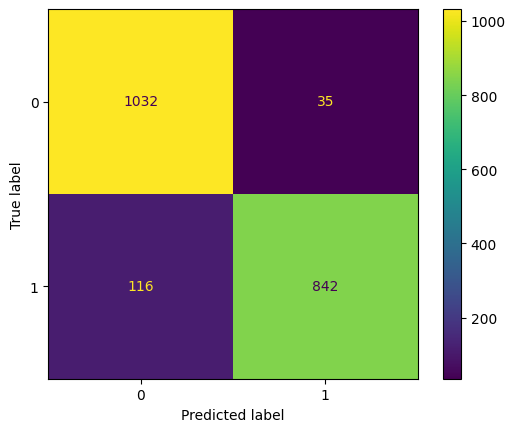

In [228]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Deep Learning ConvNet (idea from https://keras.io/examples/nlp/text_classification_from_scratch/)

In [229]:
# Disable GPU
print(tf.config.list_physical_devices('GPU'))
tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [230]:
input_shape = (1, len(X_train[0]), 1) # Batch size is the first number
print(input_shape)

X_train = allVectors

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler, "../models/cnnScaler.joblib")
X_train = scaler.transform(X_train)

X_train = np.reshape(X_train, (len(X_train), input_shape[1], input_shape[2]))
#print(X_train[30])
print(X_train.shape)
y_train = allLabels
y_train = np.reshape(y_train, (len(X_train), 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1, 1429, 1)
(10124, 1429, 1)
(8099, 1429, 1) (8099, 1) (2025, 1429, 1) (2025, 1)


In [231]:
embedding_dim = 1024
num_layers = 3


inputs = tf.keras.Input(shape=input_shape[1:], dtype="float") # Input vector
x = layers.Conv1D(embedding_dim,2, padding="valid", activation="relu", strides=3)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(embedding_dim, 2, padding="valid", activation="relu", strides=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(embedding_dim, 2, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(embedding_dim, activation="relu")(x)
x = layers.Dropout(0.5)(x)
# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)


model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

In [232]:
epochs = 128

# Fit the model using the train and test datasets.
#model.fit([X_train, y_train], validation_data=[X_test, y_test], epochs=epochs)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/128
254/254 [==============================] - 148s 578ms/step - loss: 0.6369 - binary_accuracy: 0.6571 - val_loss: 0.4808 - val_binary_accuracy: 0.7773
Epoch 2/128
254/254 [==============================] - 147s 580ms/step - loss: 0.4580 - binary_accuracy: 0.7829 - val_loss: 0.3947 - val_binary_accuracy: 0.8212
Epoch 3/128
254/254 [==============================] - 148s 581ms/step - loss: 0.4137 - binary_accuracy: 0.8091 - val_loss: 0.3779 - val_binary_accuracy: 0.8272
Epoch 4/128
254/254 [==============================] - 148s 584ms/step - loss: 0.3738 - binary_accuracy: 0.8300 - val_loss: 0.3684 - val_binary_accuracy: 0.8425
Epoch 5/128
254/254 [==============================] - 148s 583ms/step - loss: 0.3566 - binary_accuracy: 0.8457 - val_loss: 0.3182 - val_binary_accuracy: 0.8642
Epoch 6/128
254/254 [==============================] - 148s 583ms/step - loss: 0.3310 - binary_accuracy: 0.8584 - val_loss: 0.3264 - val_binary_accuracy: 0.8612
Epoch 7/128
254/254 [=============

KeyboardInterrupt: 

In [ ]:
# Test on my gmail inbox
def create_vectors_from_messages(messages, messagesPreprocessed):
    corpus = [dictionary.doc2bow(text) for text in messagesPreprocessed] # Term document frequency
    allPreprocessed = messagesPreprocessed
    allBodies = messages
    allVectors = []
    for i in range(len(allBodies)):
        topTopics = ldaModel.get_document_topics(corpus[i], minimum_probability=0.0)
        
        # Can extend this array with other stuff later
        vec = [topTopics[i][1] for i in range(numTopics)] # Topics
    
        for v in doc2VecModel.infer_vector(allPreprocessed[i]): # Doc2Vec
            vec.append(v)
    
        # Sentiment analysis of polarity
        sia = SentimentIntensityAnalyzer()
        sentence = " ".join(allPreprocessed[i])
        polarity = sia.polarity_scores(sentence)
        for s in polarity:
            vec.append(polarity[s])
    
        # Contains HTML
        if "<html>" in allBodies[i].lower():
            vec.append(1)
        else:
            vec.append(0)
    
        # Contains a link
        if "http://" in allBodies[i].lower() or "https://" in allBodies[i].lower():
            vec.append(1)
        else:
            vec.append(0)
    
        # How many blacklisted phrases/words appear in this email
        for b in blackList:
            count = 0
            for word in b:
                if word in allPreprocessed[i]:
                    count += 1
            vec.append(count)
    
        # TF-IDF for top terms
        for w in tfIDF[i]:
            vec.append(w)
    
        # Has all caps word?
        vec.append(count_all_upper_word(allBodies[i]))
    
        # Has exclamation marks?
        vec.append(allBodies[i].count("!"))
    
        # Total length
        vec.append(len(allBodies[i]))
    
        # Num words
        vec.append(len(allPreprocessed[i]))
        
        allVectors.append(vec)

    return allVectors

#box = mailbox.mbox("../datasets/monkey/phishing1.mbox")
box = mailbox.mbox("benign.mbox")
boxMessages = [m[1] for m in box.items()]
    
messages = []
for p in boxMessages:
    body = get_body_from_email(p)
    if body is not None and len(body) > 0:
        messages.append(body)

messagesDecoded = []
for m in messages:
    try:
        d = m.decode("utf-8", errors="ignore")
    except AttributeError:
        d = m
    messagesDecoded.append(d)
messages = messagesDecoded

# Apply preprocessing function to emails
messagesPreprocessed = []
for b in messages:
    p = preprocess_string(b, filters=CUSTOM_FILTERS)
    
    messagesPreprocessed.append(p)

allVectorsTest = create_vectors_from_messages(messages, messagesPreprocessed)
print("Shape of messages: {}".format(np.array(allVectorsTest).shape))

# RFC Prediction
#scaler = StandardScaler()
#scaler.fit(allVectors)
X = scaler.transform(allVectorsTest)
#y_pred = rf.predict(X)
y_pred = model.predict(X)

In [ ]:
y_pred_bin = []
numPhishesCNN = 0
for i in y_pred:
    if i > 0.5:
        y_pred_bin.append(1)
        numPhishesCNN += 1
    else:
        y_pred_bin.append(0)
print("Phishes: {}. Benign: {}.".format(numPhishesCNN, len(messages)-numPhishesCNN))
gmailAccuracyCNN = accuracy_score(gmailLabels, y_pred_bin) 
print(gmailAccuracyCNN)

In [ ]:
model.save("../models/cnn_{}l_{}d_{}e.keras".format(num_layers, embedding_dim, epochs))

In [ ]:
statsFilename = "../results/stats.csv"
if os.path.isfile(statsFilename):
    outData = {"Num Topics" : [], "TF-IDF Count" : [], "Num Training" : [], "Num Test" : [], "RFC Test Accuracy" : [], "RFC Test Recall" : [], "RFC GMail Accuracy" : [], "CNN Dim" : [], "CNN Num Layers" : [], 
               "CNN Accuracy" : [], "CNN Validation Accuracy" : [], "CNN GMail Accuracy" : [] }
    outData["Num Topics"].append(numTopics)
    outData["TF-IDF Count"].append(maximumTermCount)
    outData["Num Training"].append(len(X_train))
    outData["Num Test"].append(len(X_test))
    outData["RFC Test Accuracy"].append(rfcAccuracy)
    outData["RFC Test Recall"].append(rfcRecall)
    outData["RFC GMail Accuracy"].append(gmailAccuracy)
    outData["CNN Dim"].append(embedding_dim)
    outData["CNN Num Layers"].append(num_layers)
    outData["CNN Accuracy"].append(history.history["binary_accuracy"][-1])
    outData["CNN Validation Accuracy"].append(history.history["val_binary_accuracy"][-1])
    outData["CNN GMail Accuracy"].append(gmailAccuracyCNN)

    outDataFrame = pd.DataFrame(outData)
    
    df = pd.read_csv(statsFilename)
    print(df)
    #df = pd.concat([df, pd.DataFrame(outData)], ignore_index=True)
    outDataFrame["ID"] = len(df)
    outDataFrame.set_index("ID")
    print(outDataFrame)
    #df.loc[len(df)] = outDataFrame
    df = pd.concat([df, pd.DataFrame(outData)], ignore_index=True)
    df.to_csv(statsFilename, index=False)
else:
    outData = {"Num Topics" : [], "TF-IDF Count" : [], "Num Training" : [], "Num Test" : [], "RFC Test Accuracy" : [], "RFC Test Recall" : [], "RFC GMail Accuracy" : [], "CNN Dim" : [], "CNN Num Layers" : [], 
               "CNN Accuracy" : [], "CNN Validation Accuracy" : [], "CNN GMail Accuracy" : [] }
    outData["Num Topics"].append(numTopics)
    outData["TF-IDF Count"].append(maximumTermCount)
    outData["Num Training"].append(len(X_train))
    outData["Num Test"].append(len(X_test))
    outData["RFC Test Accuracy"].append(rfcAccuracy)
    outData["RFC Test Recall"].append(rfcRecall)
    outData["RFC GMail Accuracy"].append(gmailAccuracy)
    outData["CNN Dim"].append(embedding_dim)
    outData["CNN Num Layers"].append(num_layers)
    outData["CNN Accuracy"].append(history.history["binary_accuracy"][-1])
    outData["CNN Validation Accuracy"].append(history.history["val_binary_accuracy"][-1])
    outData["CNN GMail Accuracy"].append(gmailAccuracyCNN)
    df = pd.DataFrame(outData)
    df.to_csv(statsFilename)